In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mplhep
import uproot

import tensorflow.keras.layers
import tensorflow.keras.models
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split


Now we will comment the working environment for this VAE. The main difference in comparison to the AE is the capability to order the lattice space data into a gaussian diastribution with a given mean and standard deviation. That allows the model to be more consistent with the reconstruction and give more appropiatte results. In addition, VAE are Machine Learning algorith which are able to not only reconstruct but also create new data. On this section the mechanism of the algorithm will be explained.

The results obtained following the first approximation were not as good as expected. This model coulb be applied even though to the DeltaRij approach. By doing so, more discrimination power could be discovered.

Firstly, data will be loaded as usual. On this case, LHCb forward acceptance was chosen (eta = [2, 4.5])

In [2]:
my_file = uproot.open('MinBias.root')
tree = my_file['TupleTest/TupleTest']
data_df = tree.arrays(library='pd')
my_file.close()  # usually, it's better to open the file with a "with" statement -> needs no closing

# Show the first 5 lines of the DataFrame
data_df.head()

Px          Py            Pz          Pt             E       Eta  \
0  -82.360001   46.580002  14412.629883   94.619583  14412.940430  5.719154   
1  -19.600000   53.840000  40730.078125   57.296646  40730.121094  7.259628   
2  -69.949997 -161.399994  68758.343750  175.906113  68758.703125  6.661551   
3  422.029999 -423.790009   7772.229980  598.086365   7810.824707  3.259202   
4  -89.269997   50.880001    624.719971  102.751678    648.315491  2.504831   

        Phi     ID     PVx     PVy      PVz         OVx      OVy  \
0  2.626877   22.0 -0.0239  0.0114  80.8918   -0.023900   0.0114   
1  1.919925   22.0 -0.0239  0.0114  80.8918   -0.023900   0.0114   
2 -1.979756  211.0 -0.0239  0.0114  80.8918   -0.023900   0.0114   
3 -0.787479  321.0 -0.0239  0.0114  80.8918 -101.334999 -24.0208   
4  2.623557 -211.0 -0.0239  0.0114  80.8918 -101.334999 -24.0208   

            OVz   flight_dx  flight_dy     flight_dz  evtNumber  pvID    nPVs  
0     80.891800    0.000000     0.0000      0.000000        1.0   0.0  5512.0  
1     80.891800    0.000000     0.0000      0.000000        1.0   0.0  5512.0  
2     80.891800    0.000000     0.0000      0.000000        1.0   0.0  5512.0  
3  10298.225586  101.311096    24.0322  10217.333984        1.0   0.0  5512.0  
4  10298.225586  101.311096    24.0322  10217.333984        1.0   0.0  5512.0

In [3]:
Pt=data_df['Pt'].to_numpy()
Eta=data_df['Eta'].to_numpy()
Phi=data_df['Phi'].to_numpy()
NEvent=data_df['evtNumber'].to_numpy()
E=data_df['E'].to_numpy()
Pz=data_df['Pz'].to_numpy()
PVI=data_df['pvID'].to_numpy()
fly=data_df['flight_dz'].to_numpy()

Etadef=[]
Ptdef=[]
Phidef=[]
Neventdef=[]
Edef=[]
flydef=[]
PVIdef=[]
Pzdef=[]


for i in range(len(Eta)):
    if Eta[i] >2.0 and Eta[i]<4.5 and Pt[i]>250.0 and Pt[i] <75000. and fly[i] < 1:
        Etadef.append(Eta[i])
        Ptdef.append(Pt[i])
        Phidef.append(Phi[i])
        Neventdef.append(NEvent[i])
        Edef.append(E[i])
        flydef.append(fly[i])
        PVIdef.append(PVI[i])
        Pzdef.append(Pz[i])
        
Ptdef=np.array(Ptdef)
Etadef=np.array(Etadef)
Phidef=np.array(Phidef)
Phidef=Phidef+np.pi
Ptdef=Ptdef/1000. #GeV



Now, a cxb matrix as the 7 variable Ae will be built. The procedures are the same as in that case.

In [44]:
from sklearn.preprocessing import MinMaxScaler
scPt=MinMaxScaler(feature_range=(0,1))
scEta=MinMaxScaler(feature_range=(0,1))
scPhi=MinMaxScaler(feature_range=(0,1))
scE=MinMaxScaler(feature_range=(0,1))
scPz=MinMaxScaler(feature_range=(0,1))


b=16 #tracks per event
c=5 #Variables 
input_train=[]
input_test=[]
cuentatrain=0
cuentatest=0
totPt=[]
totEta=[]
totPhi=[]
totE=[]
totPz=[]
pttest=[]
Etatest=[]
Phitest=[]
Etest=[]
Pztest=[]
a=0
for i in range(len(PVIdef)-1): #I check the nEvents list and when I pass from one event to the following I keep the data
    if int(PVIdef[i+1])==PVIdef[i]:
        a+=1
    else:
        if a>=b: #If the number of tracks is bigger than cutoof I take the event
            pteventos=[]
            Etaeventos=[]
            Phieventos=[]
            Eeventos=[]
            Pzeventos=[]

    
            Rij=np.ones([1,b])
            pteventos=np.array(Ptdef[i-a:i+1]) #I take the data of the event
            Etaeventos=np.array(Etadef[i-a:i+1])
            Phieventos=np.array(Phidef[i-a:i+1])
            Eeventos=np.array(Edef[i-a:i+1])
            Pzeventos=np.array(Pzdef[i-a:i+1])
            
            ptML=[]
            EtaML=[]
            PhiML=[]
            EML=[]
            PzML=[]
            
            for j in range(b): #Now we are going to the take the highest pt tracks
                ptML.append(max(pteventos));indice=np.argmax(pteventos) #I take the maximun and its argument
                EtaML.append(Etaeventos[indice])
                PhiML.append(Phieventos[indice])
                EML.append(Eeventos[indice])
                PzML.append(Pzeventos[indice])
                pteventos=np.delete(pteventos,indice) #I delete the maximum and do it again
                Etaeventos=np.delete(Etaeventos,indice)
                Phieventos=np.delete(Phieventos,indice)
                Eeventos=np.delete(Eeventos,indice)
                Pzeventos=np.delete(Pzeventos,indice)
                
            
            
        
        
            ptML=np.array(ptML).reshape(-1,1);ptML=scPt.fit_transform(ptML) #I take all the elements as [],[],[] and then do the
            EtaML=np.array(EtaML).reshape(-1,1);EtaML=scEta.fit_transform(EtaML) #normalisation
            PhiML=np.array(PhiML).reshape(-1,1);PhiML=scPhi.fit_transform(PhiML)
            EML=np.array(EML).reshape(-1,1);EML=scE.fit_transform(EML)
            PzML=np.array(PzML).reshape(-1,1);PzML=scPz.fit_transform(PzML)



        
        
            
            
            
            for k in range(b): #I associate the matrix all the normalised data
                #Rij[0,k]=ptML[k][0]
                #Rij[1,k]=EtaML[k][0]
                Rij[0,k]=PhiML[k][0]
                #Rij[3,k]=EML[k][0]
                #Rij[4,k]=PzML[k][0]
                
            if cuentatrain >= 9500: #This is the number of train events I am choosing
                for l in range(b):
                    #pttest.append(ptML[l][0])
                    #Etatest.append(EtaML[l][0])
                    Phitest.append(PhiML[l][0])
                    #Etest.append(EML[l][0])
                    #Pztest.append(PzML[l][0])
                input_test.append(Rij)   
                cuentatest+=1
                a=0
            else:
                for l in range(b):
                    #totPt.append(ptML[l][0])
                    #totEta.append(EtaML[l][0])
                    totPhi.append(PhiML[l][0])
                    #totE.append(EML[l][0])
                    #totPz.append(PzML[l][0])
                input_train.append(Rij)
                cuentatrain+=1
                a=0
        else:
            a=0
            
deftrain=np.ones([cuentatrain,1,b]) #I define the tensor which will keep the data for the train
deftest=np.ones([cuentatest,1,b]) #Same for test
for i in range(cuentatrain):
    for j in range(1):
        for k in range(b):
            deftrain[i,j,k]=input_train[i][j,k]

for i in range(cuentatest):
    for j in range(1):
        for k in range(b):
            deftest[i,j,k]=input_test[i][j,k]
            
            

For SUEPs the same procedure was also followed.

In [45]:
#Now we follow the same strategy with SUEPs
from sklearn.preprocessing import MinMaxScaler
scPtSUEP=MinMaxScaler(feature_range=(0,1))
scEtaSUEP=MinMaxScaler(feature_range=(0,1))
scPhiSUEP=MinMaxScaler(feature_range=(0,1))
scESUEP=MinMaxScaler(feature_range=(0,1))
scPzSUEP=MinMaxScaler(feature_range=(0,1))
dataSUEP=pd.read_csv("SUEP_Simulation_5k_EtaShort.csv")
dfSUEP=pd.DataFrame(dataSUEP)
nTracksSUEP=dfSUEP['nTracks'].to_numpy()
nEventsSUEP=dfSUEP['Nevents'].to_numpy()
ptSUEP=dfSUEP["trackPt"].to_numpy()
etaSUEP=dfSUEP["trackEta"].to_numpy()
phiSUEP=dfSUEP["trackPhi"].to_numpy()
phiSUEP= phiSUEP + np.pi
ESUEP=dfSUEP['trackE'].to_numpy()
PzSUEP=dfSUEP['trackPz'].to_numpy()
b=16 #tracks per event
c=5 #variables we are working with
input_trainSUEP=[]
input_testSUEP=[]
cuentatrainSUEP=0
cuentatestSUEP=0
totPtSUEP=[]
totEtaSUEP=[]
totPhiSUEP=[] 
totESUEP=[] 
totPzSUEP=[] 
pttestSUEP=[]
EtatestSUEP=[]
PhitestSUEP=[]
EtestSUEP=[]
PztestSUEP=[]

for i in range(len(nEventsSUEP)-1):
    d=int(nEventsSUEP[i])
    if int(nEventsSUEP[i+1])!=d:
        a=int(nTracksSUEP[i])
        if a>=b:
            pteventosSUEP=[]
            EtaeventosSUEP=[]
            PhieventosSUEP=[]
            EeventosSUEP=[]
            PzeventosSUEP=[]

    
            RijSUEP=np.ones([1,b])
            pteventosSUEP=np.array(ptSUEP[i-a+1:i+2])
            EtaeventosSUEP=np.array(etaSUEP[i-a+1:i+2])
            PhieventosSUEP=np.array(phiSUEP[i-a+1:i+2])
            EeventosSUEP=np.array(ESUEP[i-a+1:i+2])
            PzeventosSUEP=np.array(PzSUEP[i-a+1:i+2])
            
            ptMLSUEP=[]
            EtaMLSUEP=[]
            PhiMLSUEP=[]
            EMLSUEP=[]
            PzMLSUEP=[]
            
            for j in range(b):
                ptMLSUEP.append(max(pteventosSUEP));indice=np.argmax(pteventosSUEP)
                EtaMLSUEP.append(EtaeventosSUEP[indice])
                PhiMLSUEP.append(PhieventosSUEP[indice])
                EMLSUEP.append(EeventosSUEP[indice])
                PzMLSUEP.append(PzeventosSUEP[indice])
                
                pteventosSUEP=np.delete(pteventosSUEP,indice)
                EtaeventosSUEP=np.delete(EtaeventosSUEP,indice)
                PhieventosSUEP=np.delete(PhieventosSUEP,indice)
                EeventosSUEP=np.delete(EeventosSUEP,indice)
                PzeventosSUEP=np.delete(PzeventosSUEP,indice)
                
        
            #ptMLSUEP=np.array(ptMLSUEP).reshape(-1,1);ptMLSUEP=scPtSUEP.fit_transform(ptMLSUEP)
            #EtaMLSUEP=np.array(EtaMLSUEP).reshape(-1,1);EtaMLSUEP=scEtaSUEP.fit_transform(EtaMLSUEP)
            PhiMLSUEP=np.array(PhiMLSUEP).reshape(-1,1);PhiMLSUEP=scPhiSUEP.fit_transform(PhiMLSUEP)
            #EMLSUEP=np.array(EMLSUEP).reshape(-1,1);EMLSUEP=scESUEP.fit_transform(EMLSUEP)
            #PzMLSUEP=np.array(PzMLSUEP).reshape(-1,1);PzMLSUEP=scPzSUEP.fit_transform(PzMLSUEP)


        
        
            
            
            
            for k in range(b):
                #RijSUEP[0,k]=ptMLSUEP[k][0]
                #RijSUEP[1,k]=EtaMLSUEP[k][0]
                RijSUEP[0,k]=PhiMLSUEP[k][0]
                #RijSUEP[3,k]=EMLSUEP[k][0]
                #RijSUEP[4,k]=PzMLSUEP[k][0]

                
            if cuentatrainSUEP >= 1214:
                for l in range(b):
                    #pttestSUEP.append(ptMLSUEP[l][0])
                    #EtatestSUEP.append(EtaMLSUEP[l][0])
                    PhitestSUEP.append(PhiMLSUEP[l][0])
                    #EtestSUEP.append(EMLSUEP[l][0])
                    #PztestSUEP.append(PzMLSUEP[l][0])

                input_testSUEP.append(RijSUEP)    
                cuentatestSUEP+=1
            else:
                for l in range(b):
                    #totPtSUEP.append(ptMLSUEP[l][0])
                    #totEtaSUEP.append(EtaMLSUEP[l][0])
                    totPhiSUEP.append(PhiMLSUEP[l][0])
                    #totESUEP.append(EMLSUEP[l][0])
                    #totPzSUEP.append(PzMLSUEP[l][0])
                input_trainSUEP.append(RijSUEP)
                cuentatrainSUEP+=1
                
deftrainSUEP=np.ones([cuentatrainSUEP,1,b])
deftestSUEP=np.ones([cuentatestSUEP,1,b])
for i in range(cuentatrainSUEP):
    for j in range(1):
        for k in range(b):
            deftrainSUEP[i,j,k]=input_trainSUEP[i][j,k]

for i in range(cuentatestSUEP):
    for j in range(1):
        for k in range(b):
            deftestSUEP[i,j,k]=input_testSUEP[i][j,k]
            
    

In [46]:
#On first place, the dimensionality of the image we will work with will be defined, as well as the number of channels (1 in our case)
num_channels = 1

In [61]:
#Input of the VAE; Encoder and Decoder will be built
x = tensorflow.keras.layers.Input(shape=(c, b, num_channels), name="encoder_input")

In [62]:
#Now we proceed to create the different layers of the VAE. As always, Conv2D layers were used.
# Encoder 
#On first later a 2D convolution as well as a batch normalization and a leakyrelu activation was done
encoder_conv_layer1 = tensorflow.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), padding="same", strides=1, name="encoder_conv_1")(x)
encoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_1")(encoder_conv_layer1)
encoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="encoder_leakyrelu_1")(encoder_norm_layer1)
#this layer keeps the dimensionality the same due to the strides and the padding (the kernel mixes data)

encoder_conv_layer2 = tensorflow.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_2")(encoder_activ_layer1)
encoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_2")(encoder_conv_layer2)
encoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_2")(encoder_norm_layer2)

encoder_conv_layer3 = tensorflow.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=(1,2), name="encoder_conv_3")(encoder_activ_layer2)
encoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_3")(encoder_conv_layer3)
encoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_3")(encoder_norm_layer3)

encoder_conv_layer4 = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=(1,2), name="encoder_conv_4")(encoder_activ_layer3)
encoder_norm_layer4 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_4")(encoder_conv_layer4)
encoder_activ_layer4 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_4")(encoder_norm_layer4)

encoder_conv_layer5 = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_5")(encoder_activ_layer4)
encoder_norm_layer5 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_5")(encoder_conv_layer5)
encoder_activ_layer5 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_5")(encoder_norm_layer5)

#the strides on the columns reduce that dimensionality only (16 -> 8 -> 4) and the filters increase as well as the more layers are done.


The size of the output from the last layer in the previous architecture is (5, 4, 64). So, the image size is reduced from 5x16 to just 5x4, and the number of channels is now 64. Because a VAE converts multi-dimensional data into a vector, the output must be converted into a 1D vector using a dense layer (as shown below). The purpose of the shape_before_flatten variable is to hold the shape of the result before being flattened, in order to decode the result successfully.



In [63]:
shape_before_flatten = tensorflow.keras.backend.int_shape(encoder_activ_layer5)[1:]
encoder_flatten = tensorflow.keras.layers.Flatten()(encoder_activ_layer5)

In a regular autoencoder, converting the data into a vector marks the end of the encoder. This is not the case for a VAE. The reason is that a VAE creates a standard normal distribution to represent the data. For this purpose, the parameters of the distribution (mean and variance) must be taken into account. The following code creates two layers for these two parameters.

In [64]:
#Defino el espacio final donde irá la matriz imagen y creo la media y sigma de la gaussiana del vector
#I define the final space where the image matrix will be held and I find the mean and standand deviation of 
#the gaussian distribution
latent_space_dim = 2

encoder_mu = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_mu")(encoder_flatten)
encoder_log_variance = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_log_variance")(encoder_flatten)

The units parameter in the Dense class constructor is set equal to latent_space_dim, which is a variable set to 2, representing the length of the latent vector. If you want to create a latent vector of any length, just specify the proper value for the latent_space_dim variable (done but don't know to some extent is profitable to do it, as more computational resources are needed).

Using these two layers, encoder_mu and encoder_log_variance, the normal distribution is randomly sampled to return the output of the encoder. The next line creates a custom Lambda layer for this purpose. For more information about the Lambda layer in Keras, check out the tutorial Working With The Lambda Layer in Keras.

In [65]:
#Lambda layer creation for the appliance of mu and sigma to the model

In [66]:
#This function inspects the data and distibutes them according to the paraneters mu and sigma
def sampling(mu_log_variance):
    mu, log_variance = mu_log_variance
    epsilon = tensorflow.keras.backend.random_normal(shape=tensorflow.keras.backend.shape(mu), mean=0.0, stddev=1.0)
    random_sample = mu + tensorflow.keras.backend.exp(log_variance/2) * epsilon
    return random_sample

In [67]:
encoder_output = tensorflow.keras.layers.Lambda(sampling, name="encoder_output")([encoder_mu, encoder_log_variance])

In [68]:
encoder = tensorflow.keras.models.Model(x, encoder_output, name="encoder_model")

The encoder model is done.

Now the encoder architecture from the input layer to the output layer is complete. The final remaining step is to create a model that associates the input layer to the output layer of the encoder, according to the next line.

In [69]:
encoder.summary() #Summary of the Encoder


Model: "encoder_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 1, 16, 1)]   0           []                               
                                                                                                  
 encoder_conv_1 (Conv2D)        (None, 1, 16, 16)    160         ['encoder_input[0][0]']          
                                                                                                  
 encoder_norm_1 (BatchNormaliza  (None, 1, 16, 16)   64          ['encoder_conv_1[0][0]']         
 tion)                                                                                            
                                                                                                  
 encoder_leakyrelu_1 (LeakyReLU  (None, 1, 16, 16)   0           ['encoder_norm_1[0][0

Ahora creamos el decoder

In [70]:
decoder_input = tensorflow.keras.layers.Input(shape=(latent_space_dim), name="decoder_input")

#A dense layer of the Encoder dimensionality has to be done
decoder_dense_layer1 = tensorflow.keras.layers.Dense(units=np.prod(shape_before_flatten), name="decoder_dense_1")(decoder_input)

In [71]:
#Now we transform the last layer to the dimension of the last of the encoder (5x4)
decoder_reshape = tensorflow.keras.layers.Reshape(target_shape=shape_before_flatten)(decoder_dense_layer1)

In [72]:
#We create the same neural network arquitecture but backwards. Conv2DTranspose layers have to be used and remeber where to apply the filters correct number and the strides one
decoder_conv_tran_layer1 = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_1")(decoder_reshape)
decoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_1")(decoder_conv_tran_layer1)
decoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_1")(decoder_norm_layer1)

decoder_conv_tran_layer2 = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=(1,2), name="decoder_conv_tran_2")(decoder_activ_layer1)
decoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_2")(decoder_conv_tran_layer2)
decoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_2")(decoder_norm_layer2)

decoder_conv_tran_layer3 = tensorflow.keras.layers.Conv2DTranspose(filters=32, kernel_size=(3, 3), padding="same", strides=(1,2), name="decoder_conv_tran_3")(decoder_activ_layer2)
decoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_3")(decoder_conv_tran_layer3)
decoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_3")(decoder_norm_layer3)

decoder_conv_tran_layer4 = tensorflow.keras.layers.Conv2DTranspose(filters=1, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_4")(decoder_activ_layer3)
decoder_output = tensorflow.keras.layers.LeakyReLU(name="decoder_output")(decoder_conv_tran_layer4 )


#The dimensionality of the Encoder input is recovered

In [73]:
decoder = tensorflow.keras.models.Model(decoder_input, decoder_output, name="decoder_model")#como salida la imagen
decoder.summary()

Model: "decoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 16)]              0         
                                                                 
 decoder_dense_1 (Dense)     (None, 256)               4352      
                                                                 
 reshape_2 (Reshape)         (None, 1, 4, 64)          0         
                                                                 
 decoder_conv_tran_1 (Conv2D  (None, 1, 4, 64)         36928     
 Transpose)                                                      
                                                                 
 decoder_norm_1 (BatchNormal  (None, 1, 4, 64)         256       
 ization)                                                        
                                                                 
 decoder_leakyrelu_1 (LeakyR  (None, 1, 4, 64)       

Building the VAE
In the previous two sections, two separate models for the encoder and decoder were created. In this section we will build a third model that combines the two.

One question to answer is: why build a model for the VAE if we already have the encoder and decoder? The reason is that we need to train both the encoder and the decoder at the same time, and we cannot do so when the models are separated from each other.

After completing the architectures of the encoder and the decoder, building the architecture of the VAE is so simple. All we need to do is create an input layer representing the input to the VAE (which is identical to that of the encoder).

In [74]:
vae_input = tensorflow.keras.layers.Input(shape=(1, b, num_channels), name="VAE_input") #Este es el input de verdad
vae_encoder_output = encoder(vae_input) #Ahora hago el encoder de la entrada real
vae_decoder_output = decoder(vae_encoder_output) #A continuación hago el decoder de dicha data

In [75]:
#I define the definitive model giving information of the input and collecting the correct output
vae = tensorflow.keras.models.Model(vae_input, vae_decoder_output, name="VAE")
vae.summary()

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 VAE_input (InputLayer)      [(None, 1, 16, 1)]        0         
                                                                 
 encoder_model (Functional)  (None, 16)                78528     
                                                                 
 decoder_model (Functional)  (None, 1, 16, 1)          97601     
                                                                 
Total params: 176,129
Trainable params: 175,393
Non-trainable params: 736
_________________________________________________________________


Now we will define the lost functions

# Lost Function

The lost function is needed to be done. The mathematical approach is not easy to understand, but in summarise, it takes in consideration two factors: The first one is the one associated with the reconstruction error (how similar is the output from input) whereas the second one is how well is the data closed to a normal distribution of the mean and sigma obtained in the Encoder (kl_loss). The sum of both errors has to be minimized.

In [76]:
def loss_func(encoder_mu, encoder_log_variance):
    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 1000
        reconstruction_loss = tensorflow.keras.backend.mean(tensorflow.keras.backend.square(y_true-y_predict), axis=[1,2,3])
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * tensorflow.keras.backend.sum(1.0 + encoder_log_variance - tensorflow.keras.backend.square(encoder_mu) - tensorflow.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * tensorflow.keras.backend.sum(1.0 + encoder_log_variance - tensorflow.keras.backend.square(encoder_mu) - tensorflow.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

In [77]:
#Compilamos la función error de nuestro VAE con las funciones de pérdida definidas anteriormente
#The VAE lost function is built and the model is compiled. The lost rate and the optimizers are the usual ones.
vae.compile(optimizer=tensorflow.keras.optimizers.Adam(lr=0.0005), loss=loss_func(encoder_mu, encoder_log_variance))

C:\Users\Asus\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [78]:
deftrain.shape #Just a fast check of the dimensionality. To the Encoder is necessary to add more dimension to the 
#input train set, so a reshape has to be done adding the extra dimension to the tensor.

(9500, 1, 16)

In [79]:
deftrain_final = np.reshape(deftrain, newshape=(deftrain.shape[0], deftrain.shape[1],deftrain.shape[2], 1)) 
deftest_final = np.reshape(deftest, newshape=(deftest.shape[0], deftest.shape[1],deftest.shape[2], 1)) 
deftrain_final_SUEP = np.reshape(deftrainSUEP, newshape=(deftrainSUEP.shape[0], deftrainSUEP.shape[1],deftrainSUEP.shape[2], 1)) 
deftest_final_SUEP = np.reshape(deftestSUEP, newshape=(deftestSUEP.shape[0], deftestSUEP.shape[1],deftestSUEP.shape[2], 1)) 


In [80]:
deftrain_final.shape #Checking if the dimensionality is the correct one

(9500, 1, 16, 1)

In [81]:
#Let's train the VAE
vae.fit(deftrain_final, deftrain_final, epochs=5, batch_size=16, shuffle=True, validation_data=(deftest_final, deftest_final))

Epoch 1/5
594/594 [==============================] - 8s 11ms/step - loss: 44.9678 - val_loss: 12.3692
Epoch 2/5
594/594 [==============================] - 6s 10ms/step - loss: 12.4226 - val_loss: 7.9752
Epoch 3/5
594/594 [==============================] - 6s 9ms/step - loss: 6.1009 - val_loss: 2.6168
Epoch 4/5
594/594 [==============================] - 6s 10ms/step - loss: 4.6047 - val_loss: 1.9172
Epoch 5/5
594/594 [==============================] - 6s 9ms/step - loss: 4.0040 - val_loss: 1.5006


# Anomaly Scores and Reconstruction

Reconstruction for both SM and SUEP has to be done. First, let's start with the SM test set

In [82]:
test=encoder.predict(deftest_final)
reconstructionstest=decoder.predict(test)

38/38 [==============================] - 0s 3ms/step


 We represent the MSE reconstruction error for some variables (rows of the matrix)

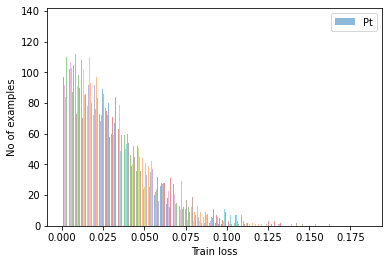

In [84]:
test_loss = tensorflow.keras.losses.mae(reconstructionstest,deftest_final)
test_array= test_loss.numpy()
#plt.hist(test_array[:,1], bins=10,alpha=0.5,label='Eta')
plt.hist(test_array[:,0], bins=50,alpha=0.5,label='Pt')
plt.legend(loc='best')
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [85]:
# Here I transform test and reconstruction data as array and do some comparison plots with the data

totaepttest=[] #AE reconstruction
totaeEtatest=[]
totaePhitest=[]
totaeEtest=[]
totaePztest=[]


for i in range(cuentatest):
    for k in range(b):
        totaepttest.append(float(reconstructionstest[i][0][k][0]))
        totaeEtatest.append(float(reconstructionstest[i][1][k][0]))
        totaePhitest.append(float(reconstructionstest[i][2][k][0]))
        totaeEtest.append(float(reconstructionstest[i][3][k][0]))
        totaePztest.append(float(reconstructionstest[i][4][k][0]))
        
totpttest=[] #Test data raw
totEtatest=[]
totPhitest=[]
totEtest=[]
totPztest=[]


for i in range(cuentatest):
    for k in range(b):
        totpttest.append(float(deftest[i][0][k]))
        totEtatest.append(float(deftest[i][1][k]))
        totPhitest.append(float(deftest[i][2][k]))        
        totEtest.append(float(deftest[i][3][k]))        
        totPztest.append(float(deftest[i][4][k]))        


Comparison plot of the reconstruction of SM test set after passing through the VAE. According to the normalized or not normalized data sets, the range for the binnig has to be changed.

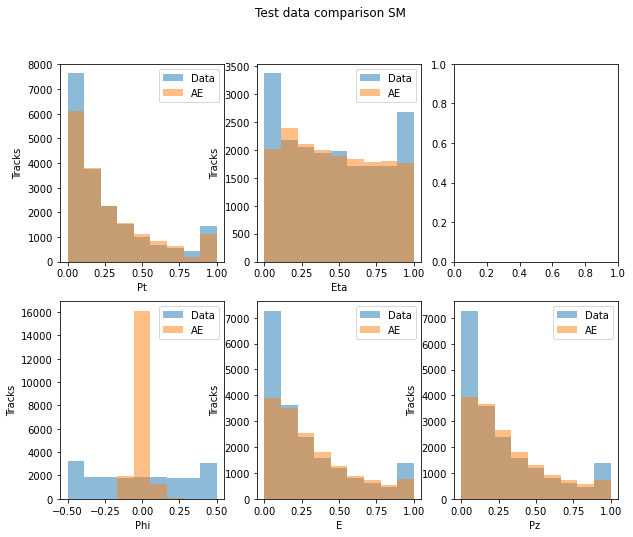

In [33]:
# now let's make some comparison plots
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2,3,sharey=False,figsize=(10,8))

fig.suptitle('Test data comparison SM')


bins = np.linspace(0,1,10)
axs[0,0].hist(totpttest, bins, alpha=0.5, label='Data')
axs[0,0].hist(totaepttest, bins, alpha=0.5, label='AE')
axs[0,0].legend(loc='upper right')
axs[0,0].set_ylabel("Tracks")
axs[0,0].set_xlabel("Pt")

bins = np.linspace(0.,1.,10)
axs[0,1].hist(totEtatest, bins, alpha=0.5, label='Data')
axs[0,1].hist(totaeEtatest, bins, alpha=0.5, label='AE')
axs[0,1].legend(loc='upper right')
axs[0,1].set_ylabel("Tracks")
axs[0,1].set_xlabel("Eta")

bins = np.linspace(-0.5,0.5,10)
axs[1,0].hist(totPhitest, bins, alpha=0.5, label='Data')
axs[1,0].hist(totaePhitest, bins, alpha=0.5, label='AE')
axs[1,0].legend(loc='upper right')
axs[1,0].set_ylabel("Tracks")
axs[1,0].set_xlabel("Phi")

bins = np.linspace(0,1,10)
axs[1,1].hist(totEtest, bins, alpha=0.5, label='Data')
axs[1,1].hist(totaeEtest, bins, alpha=0.5, label='AE')
axs[1,1].legend(loc='upper right')
axs[1,1].set_ylabel("Tracks")
axs[1,1].set_xlabel("E")

bins = np.linspace(0,1,10)
axs[1,2].hist(totPztest, bins, alpha=0.5, label='Data')
axs[1,2].hist(totaePztest, bins, alpha=0.5, label='AE')
axs[1,2].legend(loc='upper right')
axs[1,2].set_ylabel("Tracks")
axs[1,2].set_xlabel("Pz ")



plt.savefig('Comparison_Data_Test_VAE_5Variables_Short.png',dpi=300)


Now the same procedure will be followed for SUEPs.

38/38 [==============================] - 0s 3ms/step


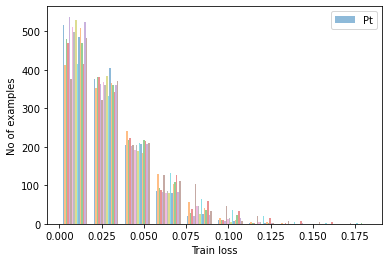

In [89]:
testSUEP=encoder.predict(deftrain_final_SUEP)
reconstructions_SUEP=decoder.predict(testSUEP)
train_loss_SUEP = tensorflow.keras.losses.mae(reconstructions_SUEP,deftrain_final_SUEP)
train_SUEP_array= train_loss_SUEP.numpy()
plt.hist(train_SUEP_array[:,0], bins=10,alpha=0.5,label='Pt')
#plt.hist(train_SUEP_array[:,2], bins=10,alpha=0.5,label='Eta')
plt.legend(loc='best')
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [90]:
#Same for SUEPs
totaepttestS=[]
totaeEtatestS=[]
totaePhitestS=[]
totaeEtestS=[]
totaePztestS=[]


for i in range(cuentatrainSUEP):
    for k in range(b):
        totaepttestS.append(float(reconstructions_SUEP[i][0][k][0]))
        totaeEtatestS.append(float(reconstructions_SUEP[i][1][k][0]))
        totaePhitestS.append(float(reconstructions_SUEP[i][2][k][0]))
        totaeEtestS.append(float(reconstructions_SUEP[i][3][k][0]))
        totaePztestS.append(float(reconstructions_SUEP[i][4][k][0]))
        
totpttestS=[]
totEtatestS=[]
totPhitestS=[]
totEtestS=[]
totPztestS=[]


for i in range(cuentatrainSUEP):
    for k in range(b):
        totpttestS.append(float(deftrainSUEP[i][0][k]))
        totEtatestS.append(float(deftrainSUEP[i][1][k]))
        totPhitestS.append(float(deftrainSUEP[i][2][k]))        
        totEtestS.append(float(deftrainSUEP[i][3][k]))        
        totPztestS.append(float(deftrainSUEP[i][4][k]))   

Comparison test set for SUEPs

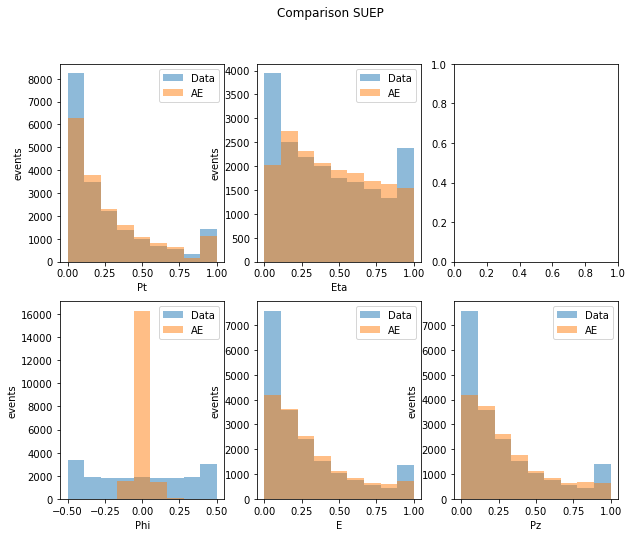

In [37]:
# now let's make some comparison plots
import matplotlib.pyplot as plt
import numpy as np

del fig 
fig, axs = plt.subplots(2,3,sharey=False,figsize=(10,8))

fig.suptitle('Comparison SUEP')


bins = np.linspace(0,1,10)
axs[0,0].hist(totpttestS, bins, alpha=0.5, label='Data')
axs[0,0].hist(totaepttestS, bins, alpha=0.5, label='AE')
axs[0,0].legend(loc='upper right')
axs[0,0].set_ylabel("events")
axs[0,0].set_xlabel("Pt")

bins = np.linspace(0,1,10)
axs[0,1].hist(totEtatestS, bins, alpha=0.5, label='Data')
axs[0,1].hist(totaeEtatestS, bins, alpha=0.5, label='AE')
axs[0,1].legend(loc='upper right')
axs[0,1].set_ylabel("events")
axs[0,1].set_xlabel("Eta")

bins = np.linspace(-0.5,0.5,10)
axs[1,0].hist(totPhitestS, bins, alpha=0.5, label='Data')
axs[1,0].hist(totaePhitestS, bins, alpha=0.5, label='AE')
axs[1,0].legend(loc='upper right')
axs[1,0].set_ylabel("events")
axs[1,0].set_xlabel("Phi")

bins = np.linspace(0,1,10)
axs[1,1].hist(totEtestS, bins, alpha=0.5, label='Data')
axs[1,1].hist(totaeEtestS, bins, alpha=0.5, label='AE')
axs[1,1].legend(loc='upper right')
axs[1,1].set_ylabel("events")
axs[1,1].set_xlabel("E")

bins = np.linspace(0,1,10)
axs[1,2].hist(totPztestS, bins, alpha=0.5, label='Data')
axs[1,2].hist(totaePztestS, bins, alpha=0.5, label='AE')
axs[1,2].legend(loc='upper right')
axs[1,2].set_ylabel("events")
axs[1,2].set_xlabel("Pz")



plt.savefig('Comparison_SUEP_Test_VAE_5Variables_Short.png',dpi=300)

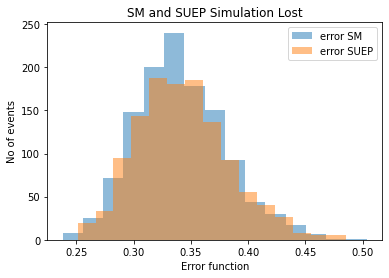

In [38]:
#No we apply the anomaly score as SF from the SUEP paper to the reconstructed data sets for SM and SUEPs

def sigma(a):
        sigma=1./(1.+np.exp(-a))
        return sigma

errorevent=[]
for i in range(cuentatest):
    suma=0
    for j in range(c):
        for k in range(b):
            numerador=np.abs(reconstructionstest[i,j,k,0]-sigma(deftest[i,j,k]))**3
            suma+=numerador
    error=suma/b
    errorevent.append(error)
    
erroreventSUEP=[]
for i in range(cuentatrainSUEP):
    suma=0
    for j in range(c):
        for k in range(b):
            numerador=np.abs(reconstructions_SUEP[i,j,k,0]-sigma(deftrainSUEP[i,j,k]))**3
            suma+=numerador
    errorSUEP=suma/b
    erroreventSUEP.append(errorSUEP)

plt.hist(errorevent, bins=15,alpha=0.5,label='error SM')
plt.hist(erroreventSUEP, bins=15,alpha=0.5,label='error SUEP')
plt.title('SM and SUEP Simulation Lost')
plt.xlabel("Error function")
plt.ylabel("No of events")
plt.legend(loc='best')
plt.savefig('Loss_VAE_SM_SUEP_VAE5_5Variables_Sigma_Short.png', dpi=400)

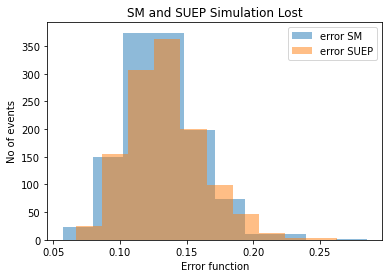

In [39]:
#No we apply MSE as anomaly score

def sigma(a):
        sigma=1./(1.+np.exp(-a))
        return sigma

errorevent=[]
for i in range(cuentatest):
    suma=0
    for j in range(c):
        for k in range(b):
            numerador=np.abs(reconstructionstest[i,j,k,0]-deftest[i,j,k])**2
            suma+=numerador
    error=suma/b
    errorevent.append(error)
    
erroreventSUEP=[]
for i in range(cuentatrainSUEP):
    suma=0
    for j in range(c):
        for k in range(b):
            numerador=np.abs(reconstructions_SUEP[i,j,k,0]-deftrainSUEP[i,j,k])**2
            suma+=numerador
    errorSUEP=suma/b
    erroreventSUEP.append(errorSUEP)

plt.hist(errorevent, bins=10,alpha=0.5,label='error SM')
plt.hist(erroreventSUEP, bins=10,alpha=0.5,label='error SUEP')
plt.title('SM and SUEP Simulation Lost')
plt.xlabel("Error function")
plt.ylabel("No of events")
plt.legend(loc='best')
plt.savefig('Loss_VAE_SM_SUEP_VAE5_5Variables_Custom_MSE_Short.png', dpi=400)